In [2]:
import cPickle as pickle
import numpy as np
import tensorflow as tf



with open("read_data.pickle", "r") as f:
    x = pickle.load(f)
    train_pics = x["pics"]
    train_labels = x["labels"]
    
print train_pics.shape, train_labels.shape


def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])



(132, 480, 640, 3) (132, 4)


In [3]:
# print train_pics[0]
train_pics = (train_pics -128)/256.0
print train_pics

[[[[ 0.91015625  0.921875    0.94140625]
   [ 0.76953125  0.78125     0.80078125]
   [ 0.875       0.8828125   0.9140625 ]
   ..., 
   [ 0.4375      0.47265625  0.48828125]
   [ 0.38671875  0.421875    0.4375    ]
   [ 0.97265625  0.0078125   0.0234375 ]]

  [[ 0.265625    0.27734375  0.296875  ]
   [ 0.94921875  0.9609375   0.98046875]
   [ 0.85546875  0.86328125  0.89453125]
   ..., 
   [ 0.42578125  0.4609375   0.4765625 ]
   [ 0.3828125   0.41796875  0.43359375]
   [ 0.95703125  0.9921875   0.0078125 ]]

  [[ 0.48828125  0.484375    0.49609375]
   [ 0.3203125   0.31640625  0.3515625 ]
   [ 0.97265625  0.9765625   0.015625  ]
   ..., 
   [ 0.43359375  0.45703125  0.4765625 ]
   [ 0.40234375  0.42578125  0.4453125 ]
   [ 0.94921875  0.97265625  0.9921875 ]]

  ..., 
  [[ 0.80859375  0.84375     0.8984375 ]
   [ 0.80859375  0.83984375  0.890625  ]
   [ 0.8203125   0.828125    0.8671875 ]
   ..., 
   [ 0.734375    0.77734375  0.85546875]
   [ 0.75        0.79296875  0.87109375]
   [ 0.

In [4]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

train_pics, train_labels = randomize(train_pics, train_labels)

In [13]:
batch_size = 64
patch_size1 = 10
patch_size2 = 5
depth1 = 9
depth2 = 24
num_hidden = 128
image_height = 480
image_width = 640
num_channels = 3
num_labels = 4

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_height, image_width, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
#   tf_valid_dataset = tf.constant(valid_dataset)
  
  tf_test_data = tf.placeholder(
    tf.float32, shape=(1, image_height, image_width, num_channels))
    
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size1, patch_size1, num_channels, depth1], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth1]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size2, patch_size2, depth1, depth2], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [6384, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  

  # Model.
  def model(data):
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, 4, 4, 1], padding='VALID')
    bias1 = tf.nn.relu(conv1 + layer1_biases)
    pool1 = tf.nn.max_pool(bias1, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    conv2 = tf.nn.conv2d(pool1, layer2_weights, [1, 2, 2, 1], padding='VALID')
    bias2 = tf.nn.relu(conv2 + layer2_biases)
    pool2 = tf.nn.max_pool(bias2, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    shape = pool2.get_shape().as_list()
    reshape = tf.reshape(pool2, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
 
  with tf.device("/gpu:0"):
      # Training computation.
      logits = model(tf_train_dataset)
      loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

      # Optimizer.
      optimizer = tf.train.GradientDescentOptimizer(0.005).minimize(loss)

      # Predictions for the training, validation, and test data.
      train_prediction = tf.nn.softmax(logits)
    #   valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    #   test_prediction = tf.nn.softmax(model(tf_test_dataset))
        
        
      test_prediction = tf.nn.softmax(model(tf_test_data))
  saver = tf.train.Saver()

num_steps = 101

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    train_pics, train_labels = randomize(train_pics, train_labels)
    
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_pics[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
#         print (predictions.shape)

    if (step % 10 == 0):
      print('Minibatch loss at step %d: %0.2f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
#       print predictions
        
    if (step % 50 == 0):

        saver.save(session, "model"+str(step)+".ckpt")

  while 1:
        time.sleep(5)
        ret, raw = camera.retrieve()

        raw = (raw-128)/256.0
        plt.imshow(raw*256.0+128)
        plt.show()

        if ret:
            feed_dict = {tf_test_data: np.array([raw])}
            prediction = session.run(test_prediction, feed_dict=feed_dict)
            prediction = list(prediction[0])
            print prediction
            if prediction.index(max(prediction))==0:
                s.send("ff 0.4")
                print "ff"
            elif prediction.index(max(prediction))==1:
                s.send("bb 0.4")
                print "bb"
            elif prediction.index(max(prediction))==2:
                s.send("ll 0.4")
                print "ll"
            elif prediction.index(max(prediction))==3:
                s.send("rr 0.4")
                print "rr"

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 13.81
Minibatch accuracy: 23.4%
Minibatch loss at step 10: 1.89
Minibatch accuracy: 17.2%
Minibatch loss at step 20: 1.25
Minibatch accuracy: 39.1%
Minibatch loss at step 30: 1.03
Minibatch accuracy: 50.0%
Minibatch loss at step 40: 0.95
Minibatch accuracy: 59.4%
Minibatch loss at step 50: 0.79
Minibatch accuracy: 73.4%
Minibatch loss at step 60: 0.70
Minibatch accuracy: 79.7%
Minibatch loss at step 70: 0.65
Minibatch accuracy: 79.7%
Minibatch loss at step 80: 0.67
Minibatch accuracy: 76.6%
Minibatch loss at step 90: 0.67
Minibatch accuracy: 73.4%
Minibatch loss at step 100: 0.60
Minibatch accuracy: 79.7%


TypeError: unsupported operand type(s) for -: 'NoneType' and 'int'

[ 0.  0.  1.  0.]


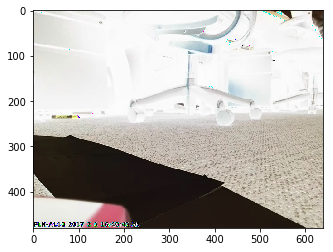

[ 0.  0.  0.  1.]


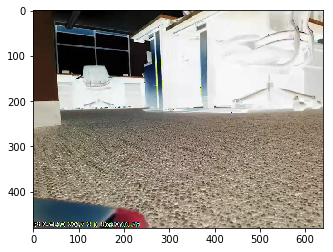

[ 0.  0.  1.  0.]


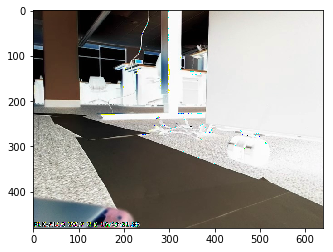

[ 0.  1.  0.  0.]


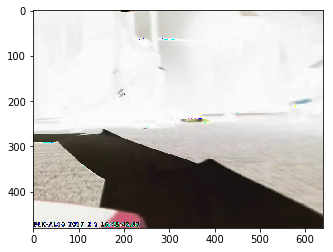

[ 0.  0.  1.  0.]


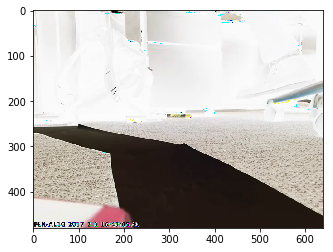

[ 1.  0.  0.  0.]


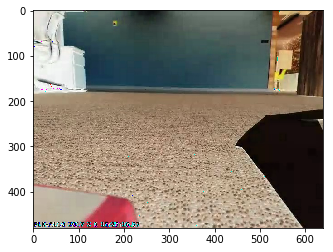

[ 0.  1.  0.  0.]


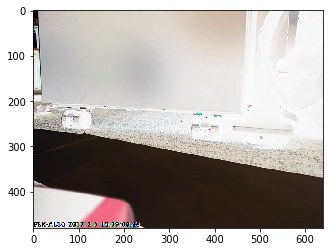

[ 0.  0.  1.  0.]


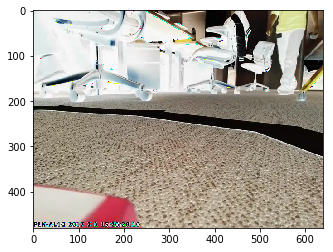

[ 1.  0.  0.  0.]


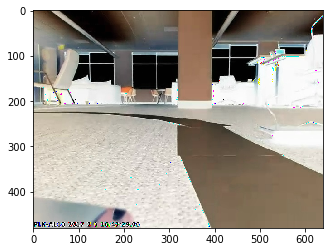

[ 0.  0.  0.  1.]


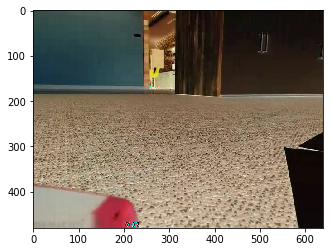

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

for ii in range(10):
    plt.imshow(train_pics[ii] * 256.0 + 128.0)
    print train_labels[ii]
    plt.show()
    


In [82]:
sess = tf.Session(graph=graph)
new_saver = tf.train.import_meta_graph('model0.meta')
new_saver.restore(sess, tf.train.latest_checkpoint('./'))
all_vars = tf.get_collection('vars')


train_pics, train_labels = randomize(train_pics, train_labels)
offset = (0 * batch_size) % (train_labels.shape[0] - batch_size)
batch_data = train_pics[offset:(offset + batch_size-1), :, :, :]
batch_labels = train_labels[offset:(offset + batch_size-1), :]


feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
prediction = sess.run(
  train_prediction, feed_dict=feed_dict)

print('Minibatch loss at step %d: %0.2f' % (1, l))
print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))

ValueError: Cannot feed value of shape (31, 480, 640, 3) for Tensor u'Placeholder:0', which has shape '(32, 480, 640, 3)'

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
[[  1.68013214e-09   1.54553786e-10   1.00000000e+00   2.46214646e-11]]
[ 0.  0.  1.  0.]


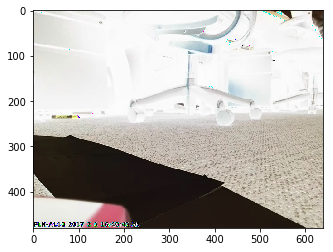

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
[[  8.48929121e-05   5.91388531e-03   8.93167407e-09   9.94001210e-01]]
[ 0.  0.  0.  1.]


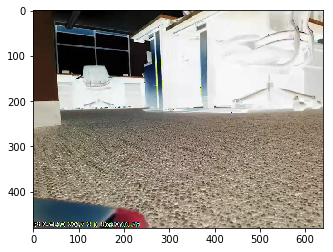

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
[[  9.91654992e-01   7.99024664e-03   3.54808726e-04   1.38575186e-12]]
[ 0.  0.  1.  0.]


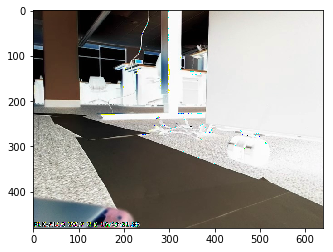

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
[[  5.17514243e-04   7.62733042e-01   1.08316244e-05   2.36738607e-01]]
[ 0.  1.  0.  0.]


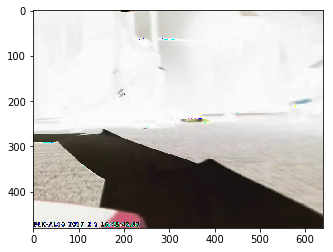

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
[[  6.95141435e-01   6.32807836e-02   1.89680759e-05   2.41558760e-01]]
[ 0.  0.  1.  0.]


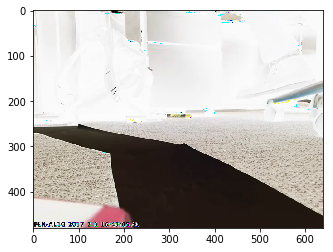

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
[[  8.64782638e-12   1.39249892e-08   9.99995947e-01   4.02068872e-06]]
[ 1.  0.  0.  0.]


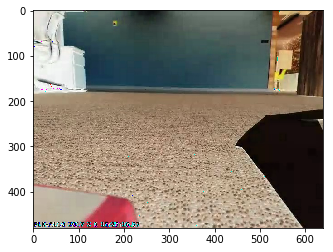

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
[[ 0.00168775  0.10215127  0.05153581  0.84462517]]
[ 0.  1.  0.  0.]


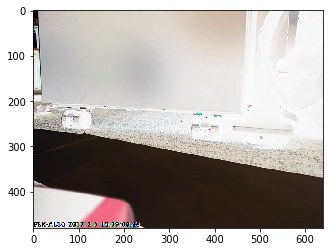

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
[[  1.00000000e+00   5.09319831e-09   6.21413643e-10   2.68972535e-11]]
[ 0.  0.  1.  0.]


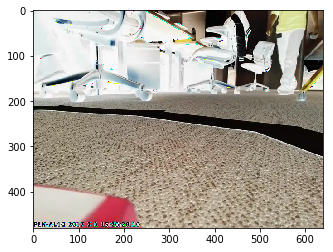

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
[[  1.05687669e-02   2.15572407e-04   3.55335884e-02   9.53682005e-01]]
[ 1.  0.  0.  0.]


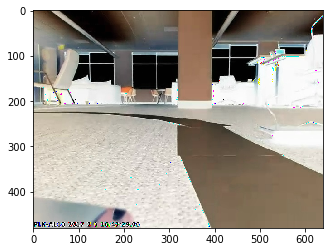

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
[[  9.77130532e-01   1.44863279e-05   2.28358507e-02   1.92534299e-05]]
[ 0.  0.  0.  1.]


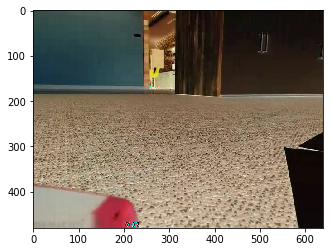

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
[[  9.29759979e-01   2.63111535e-02   4.18166138e-07   4.39284667e-02]]
[ 0.  0.  0.  1.]


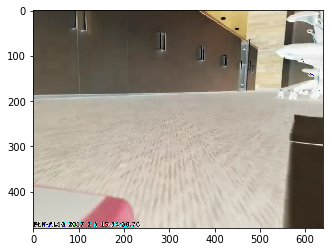

In [7]:
test_num = 2
for test_num in range(11):
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        print('Initialized')
        feed_dict = {tf_test_data: np.array([train_pics[test_num]])}
        prediction = session.run(test_prediction, feed_dict=feed_dict)
        print prediction

    plt.imshow(train_pics[test_num] * 256.0 + 128.0)
    print train_labels[test_num]
    plt.show()

Initialized


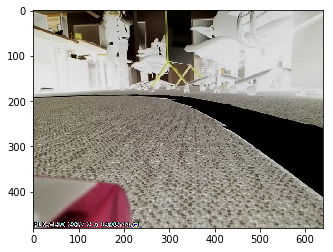

[0.59067839, 0.30300733, 0.082429655, 0.023884717]
ff


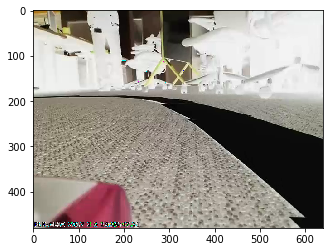

[0.59387487, 0.1131857, 0.18931358, 0.10362588]
ff


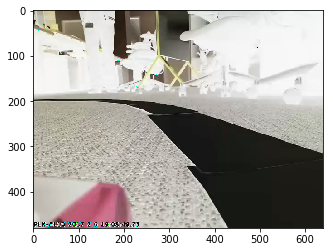

[0.46608019, 0.20081088, 0.27049404, 0.062614851]
ff


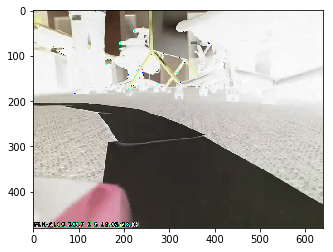

[0.033872999, 0.45186529, 0.50187242, 0.012389242]
ll


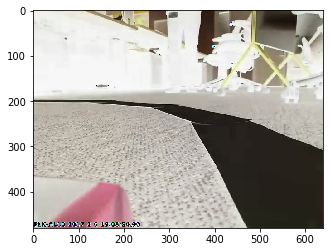

[0.51824027, 0.063624397, 0.30768982, 0.11044552]
ff


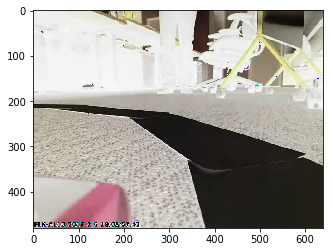

[0.18390048, 0.072194405, 0.63128889, 0.11261627]
ll


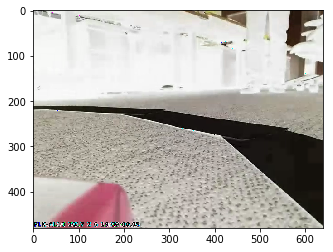

[0.78991449, 0.024422778, 0.097263493, 0.088399284]
ff


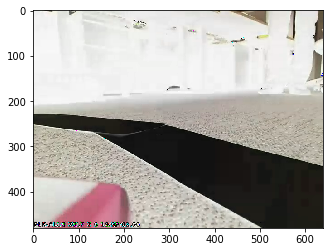

[0.086607121, 0.21342333, 0.6439625, 0.056007031]
ll


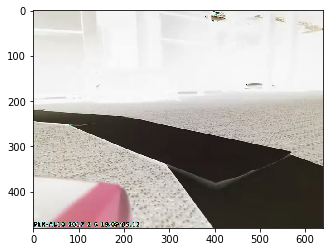

[0.075116806, 0.16340016, 0.64878041, 0.11270261]
ll


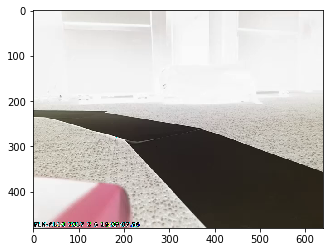

[0.095163189, 0.16764627, 0.61895448, 0.11823605]
ll


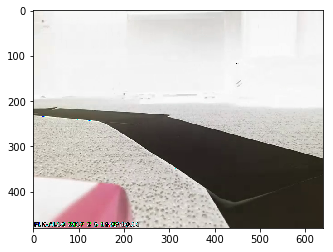

[0.1435979, 0.17342904, 0.62514174, 0.05783131]
ll


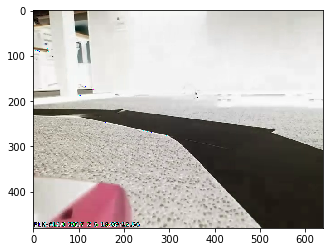

[0.53320128, 0.15552503, 0.25583306, 0.055440616]
ff


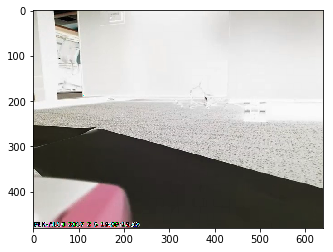

[0.011400728, 0.63719165, 0.32970729, 0.021700287]
bb


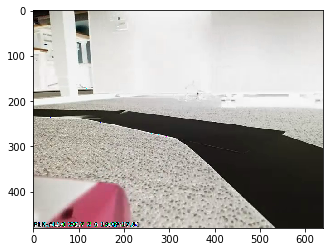

[0.53121912, 0.12768419, 0.30420071, 0.036895987]
ff


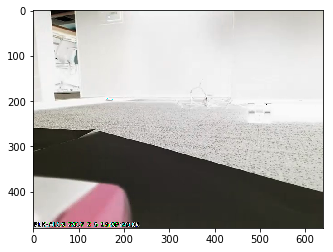

[0.018643467, 0.5178526, 0.43444625, 0.029057764]
bb


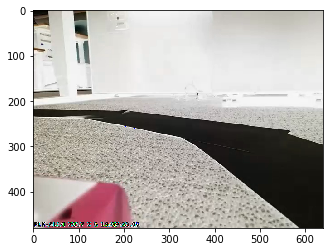

[0.55934781, 0.16814922, 0.22833246, 0.044170536]
ff


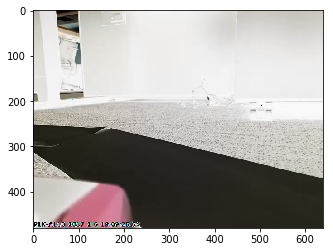

[0.0088223731, 0.78843963, 0.18767497, 0.01506302]
bb


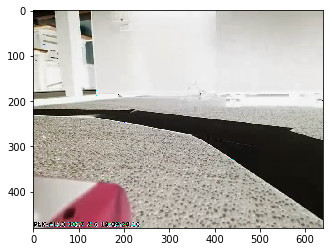

[0.60806161, 0.12241527, 0.20418982, 0.065333299]
ff


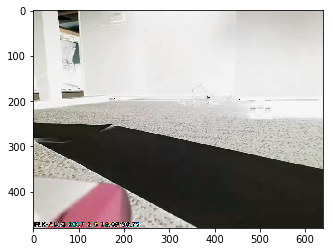

[0.018067263, 0.55032486, 0.41436005, 0.017247772]
bb


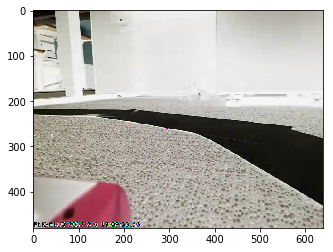

[0.61191827, 0.11276747, 0.19140521, 0.08390899]
ff


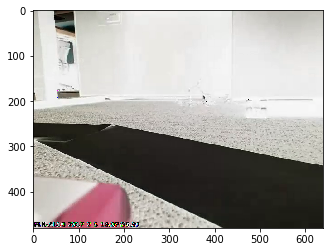

[0.024167676, 0.3372989, 0.61950994, 0.019023526]
ll


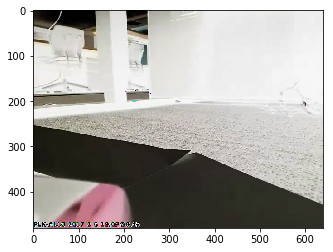

[0.026638472, 0.68195921, 0.26065746, 0.030744897]
bb


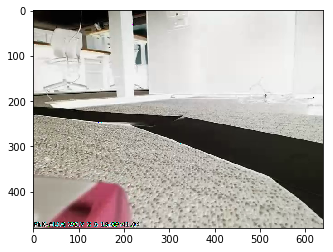

[0.60802752, 0.060239334, 0.26412192, 0.06761121]
ff


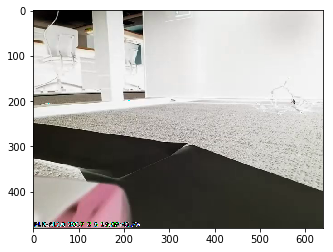

[0.012729506, 0.68023205, 0.28766313, 0.019375291]
bb


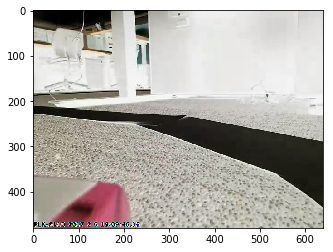

[0.66236538, 0.078189008, 0.18446717, 0.074978456]
ff


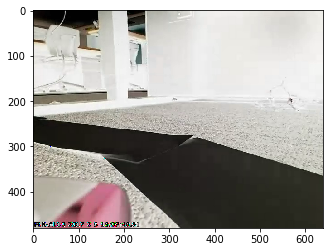

[0.088816315, 0.49163312, 0.36917669, 0.050373916]
bb


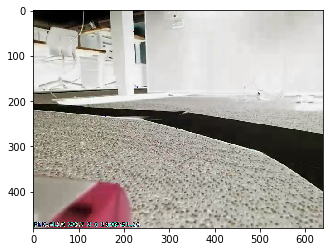

[0.48893762, 0.26453283, 0.16730237, 0.079227202]
ff


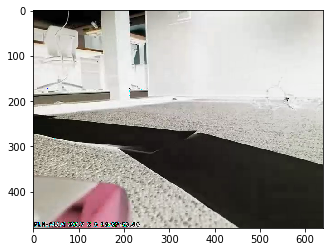

[0.095230743, 0.17939876, 0.66267163, 0.062698826]
ll


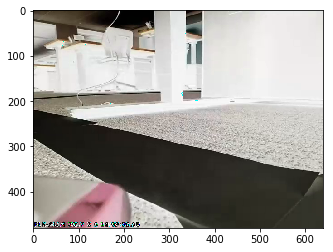

[0.014520203, 0.55724543, 0.37786391, 0.050370503]
bb


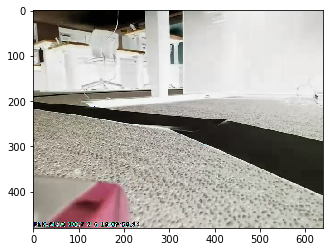

[0.6203354, 0.13563527, 0.18738088, 0.056648452]
ff


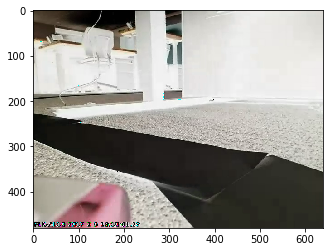

[0.024050044, 0.28326002, 0.60299653, 0.089693412]
ll


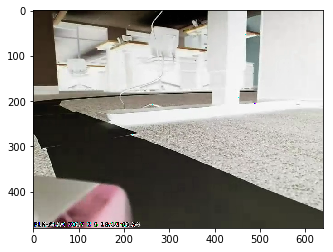

[0.0095766736, 0.65519065, 0.32053649, 0.014696176]
bb


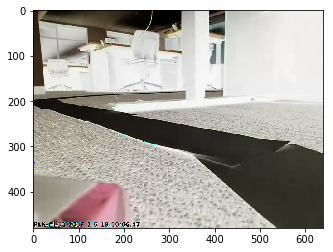

[0.65793145, 0.087870337, 0.17308198, 0.081116349]
ff


In [ ]:
import threading, cv2, time
import socket
%matplotlib inline
import matplotlib.pyplot as plt

class Grabber(threading.Thread):
    def __init__(self, cam):
        threading.Thread.__init__(self)
        self.cam = cam
        self.lock = threading.Lock()
        self.running = True
        self.start()
    def run(self):
        while self.running:
            time.sleep(0.01)
            with self.lock:
                self.cam.grab()
    def stop(self):
        self.running = False
    def retrieve(self):
        with self.lock:
            return self.cam.retrieve()
    def restart(self):
        self.cam.set(cv2.CAP_PROP_POS_FRAMES, 0)
        

address = ('10.157.120.38', 8009)
s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
s.connect(address)


camera = Grabber(cv2.VideoCapture("rtsp://10.155.70.237:5554/playlist.m3u"))

with tf.Session(graph=graph) as session:
    saver.restore(session, "./model100.ckpt")
#     tf.global_variables_initializer().run()    
    print('Initialized')
    while 1:
        time.sleep(2)
        ret, raw = camera.retrieve()

        raw = (raw-128)/256.0
        plt.imshow(raw*256.0+128)
        plt.show()
        
        if ret:
            feed_dict = {tf_test_data: np.array([raw])}
            prediction = session.run(test_prediction, feed_dict=feed_dict)
            prediction = list(prediction[0])
            print prediction
            if prediction.index(max(prediction))==0:
                s.send("ff 0.4")
                print "ff"
            elif prediction.index(max(prediction))==1:
                s.send("bb 0.3")
                print "bb"
            elif prediction.index(max(prediction))==2:
                s.send("ll 0.4")
                print "ll"
            elif prediction.index(max(prediction))==3:
                s.send("rr 0.4")
                print "rr"

                